Solution is stable (alpha = 0.2425252525252526)


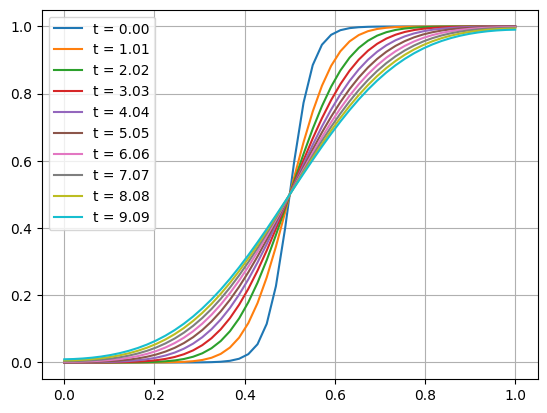

In [9]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

# Set problem parameters/constants
k = 0.001  # Diffusion constant
L = 1    # Length of domain
T = 10  # Time to solve until
Nx = 50  # Number of spatial points in grid
Nt = 100  # Number of time steps

dx = L / (Nx - 1)  # Spatial discretization size
dt = T / (Nt - 1)  # Time discretization size

alpha = k * dt / dx**2  # Coefficient for scheme

x = np.linspace(0, L, Nx)
# Ensure the method is stable
if alpha < 0.5:
    print(f"Solution is stable (alpha = {alpha})")
else:
    print(f"Solution may be unstable (alpha = {alpha})")

# Initialize grid
grid = np.zeros(shape=(Nt, Nx))

# Initial condition
# grid[0, :] = np.sin(np.pi * np.linspace(0, L, Nx))
grid[0, :] = 0.5+0.5*np.tanh((x- L/2) * 20 )

# Create the matrix A
A = np.diag((1 + 2*alpha) * np.ones(Nx))
A += np.diag(-alpha * np.ones(Nx - 1), k=-1)
A += np.diag(-alpha * np.ones(Nx - 1), k=1)

# Create the matrix B
B = np.diag((1 - 2*alpha) * np.ones(Nx))
B += np.diag(alpha * np.ones(Nx - 1), k=-1)
B += np.diag(alpha * np.ones(Nx - 1), k=1)

# Modify the matrices to account for the zero-gradient boundary condition
A[0, 0] = A[-1, -1] = 1 + alpha
A[0, 1] = A[-1, -2] = -alpha
B[0, 0] = B[-1, -1] = 1 - alpha
B[0, 1] = B[-1, -2] = alpha

# Crank-Nicolson scheme
for t in range(Nt - 1):
    b = B @ grid[t, :]
    grid[t + 1, :] = solve(A, b)


# Plot solution
for t in range(Nt):
    if t % 10 == 0:  # Only plot every 10th time step
        plt.plot(x, grid[t, :], label=f"t = {t * dt:.2f}")

plt.legend()
plt.grid()
plt.show()


#Solution may be unstable (alpha = 2.4500000000000006)



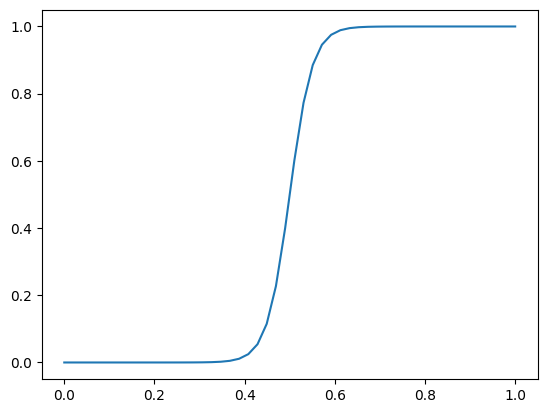

In [10]:
grid[0, :] = 0.5+0.5*np.tanh((x- L/2) * 20 )
plt.plot(x,grid[0,:])

In [11]:
def solve_diffusion(k0, L, T, Nx, Nt, a, b, n=1):
    """
    Solves the 1D diffusion equation with zero-gradient boundary conditions
    and an AR(1) process for the diffusion coefficient using the Crank-Nicolson method.

    Parameters
    ----------
    k0 : float
        Mean diffusion constant.
    L : float
        Length of domain.
    T : float
        Time to solve until.
    Nx : int
        Number of spatial points in grid.
    Nt : int
        Number of time steps.
    a : float
        Autoregressive coefficient.
    b : float
        Scale factor for the white noise.
    n : float
        Order of the k term.

    Returns
    -------
    grid : 2D numpy.ndarray
        The solution at all time steps.
    """

    dx = L / (Nx - 1)  # Spatial discretization size
    dt = T / (Nt - 1)  # Time discretization size

    # Initialize grid
    grid = np.zeros(shape=(Nt, Nx))

    # Initial condition
    grid[0, :] = 0.5+0.5*np.tanh((x- 3.5*L/4) * 20 )

    # Generate AR(1) process for k
    # np.random.seed(0)  # For reproducibility
    epsilon  = np.random.normal(size=Nt)
    phi_ar1    = np.zeros(Nt)
    if a<1:
        phi_ar1[0] = np.sqrt(b**2/(1-a**2)) * epsilon[0]
    else:
        phi_ar1[0] = 0.
    
    for t in range(1, Nt):
        phi_ar1[t] = a * phi_ar1[t-1] + b * epsilon[t]

    #k_ar1 = k0 + 1*phi_ar1 # Linear model
    k_ar1 = k0 + 1*phi_ar1**n # Non-Linear model
    
    # Crank-Nicolson scheme with AR(1) process for k
    for t in range(Nt - 1):
        alpha = k_ar1[t] * dt / dx**2  # Update alpha at each time step

        # Create the matrix A
        A = np.diag((1 + 2*alpha) * np.ones(Nx))
        A += np.diag(-alpha * np.ones(Nx - 1), k=-1)
        A += np.diag(-alpha * np.ones(Nx - 1), k=1)

        # Create the matrix B
        B = np.diag((1 - 2*alpha) * np.ones(Nx))
        B += np.diag(alpha * np.ones(Nx - 1), k=-1)
        B += np.diag(alpha * np.ones(Nx - 1), k=1)

        # Modify the matrices to account for the zero-gradient boundary condition
        A[0, 0] = A[-1, -1] = 1 + alpha
        A[0, 1] = A[-1, -2] = -alpha
        B[0, 0] = B[-1, -1] = 1 - alpha
        B[0, 1] = B[-1, -2] = alpha

        b = B @ grid[t, :]
        grid[t + 1, :] = solve(A, b)

    return grid, k_ar1


Text(0.5, 1.0, 'n=1')

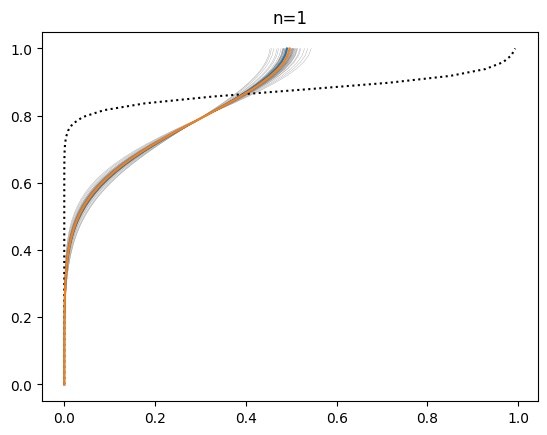

In [12]:
# Use the function to solve the diffusion equation
k = 0.001  # Diffusion constant
L = 1    # Length of domain
T = 10  # Time to solve until
Nx = 50  # Number of spatial points in grid
Nt = 100  # Number of time steps

n = 1
b = (0.1*k)**(1/n)

u_mu, _ = solve_diffusion(k0=k, L=L, T=T, Nx=Nx, Nt=Nt, a=1., b=0., n=n)

x = np.linspace(0, L, Nx)

# plt.plot(u[0,:], x)
nens = 50
u_ens = np.zeros((x.shape[0], nens))
for ii in range(nens):
    # u, k_ar1 = solve_diffusion(k0=k, L=L, T=T, Nx=Nx, Nt=Nt, a=0.9, b=0.1*k)
    
    u, k_ar1 = solve_diffusion(k0=k, L=L, T=T, Nx=Nx, Nt=Nt, a=0.9, b=b, n=n)
    u_ens[:,ii] = u[-1,:]
    
    plt.plot(u_ens[:,ii], x,'0.5', lw=0.2 )

plt.plot(u_mu[0,:], x , 'k:', label='I.C.')
plt.plot(u_mu[-1,:], x )
plt.plot(u_ens.mean(axis=1), x)

plt.title(f'n={n}')

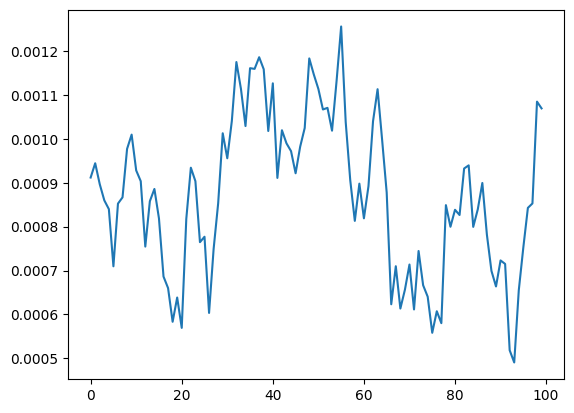

In [13]:
plt.plot(k_ar1)

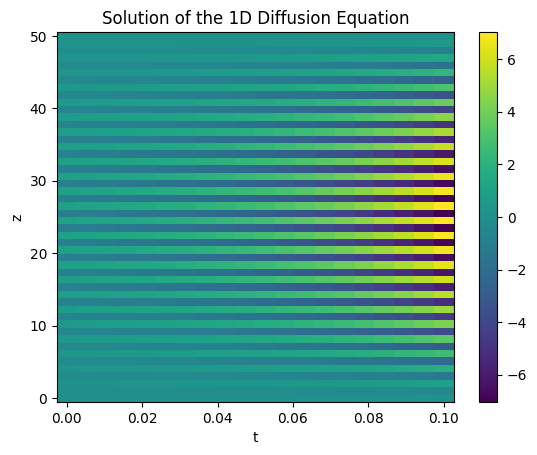

In [14]:
# Use meta.ai with prompts
# >python code for 1d diffusion equation
# >use crank nicholson time stepping
# >use a tanh function for initial conditions
# >use zero gradient boundary conditions
# >where is the time step term?

import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
L = 50.0         # length of the domain
T = 0.1         # total time
nx = 50        # number of grid points
nt = 20        # number of time steps
D = 0.1         # diffusion coefficient

# Create the grid
x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)

# Create the initial condition
u0 = 0.5+0.5**np.tanh((x - L/2) )

dt = T / nt    # time step

# Create the grid
x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)

# Create the initial condition
u0 = np.sin(np.pi * x)

# Create the finite difference matrix
A = np.zeros((nx, nx))
A[0, 0] = 1
A[nx-1, nx-1] = 1
for i in range(1, nx-1):
  A[i, i-1] = -D / (4 * (x[1] - x[0]))
  A[i, i] = 1
  A[i, i+1] = -D / (4 * (x[1] - x[0]))

# Apply zero gradient boundary conditions
A[1, 0] = 0
A[nx-2, nx-1] = 0

# Create the boundary condition matrix
B = np.zeros((nx, nx))
B[0, 0] = 1
B[nx-1, nx-1] = 1
for i in range(1, nx-1):
  B[i, i-1] = D / (4 * (x[1] - x[0]))
  B[i, i] = 1
  B[i, i+1] = D / (4 * (x[1] - x[0]))

# Apply zero gradient boundary conditions
B[1, 0] = 0
B[nx-2, nx-1] = 0

# Solve the equation
u = np.zeros((nx, nt))
u[:, 0] = u0
for n in range(1, nt):
  u[:, n] = np.linalg.solve(B, (A @ u[:, n-1] + dt * u[:, n-1]))

# Plot the solution
plt.figure()
plt.pcolormesh(t, x,u)
plt.xlabel('t')
plt.ylabel('z')
plt.title('Solution of the 1D Diffusion Equation')
plt.colorbar()

plt.show()

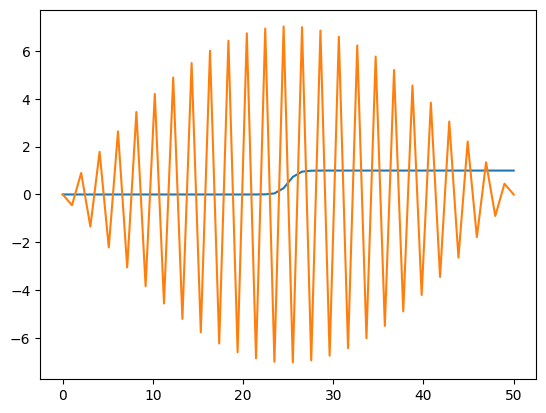

In [15]:
u0 = 0.5+0.5*np.tanh((x - L/2) )

plt.plot(x, u0)
plt.plot(x, u[:,-1])

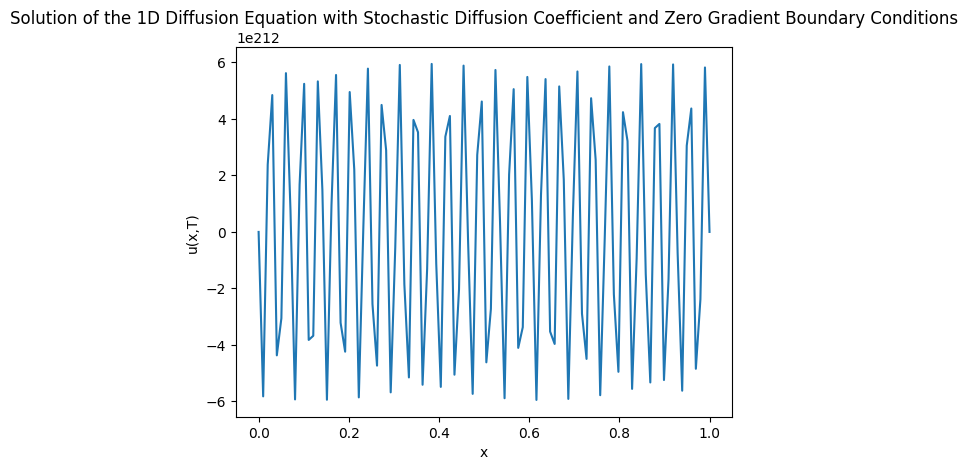

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
L = 1.0         # length of the domain
T = 0.1         # total time
nx = 100        # number of grid points
nt = 100        # number of time steps
D_mean = 0.1    # mean diffusion coefficient
D_var = 0.01    # variance of diffusion coefficient
phi = 0.9       # AR(1) parameter
eps_std = 0.1   # standard deviation of innovation term

# Create the grid
x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)

# Create the initial condition
u0 = np.tanh((x - 0.5) / 0.1)

# Create the finite difference matrix
A = np.zeros((nx, nx))
A[0, 0] = 1
A[nx-1, nx-1] = 1
for i in range(1, nx-1):
  A[i, i-1] = -D_mean / (4 * (x[1] - x[0]))
  A[i, i] = 1
  A[i, i+1] = -D_mean / (4 * (x[1] - x[0]))

# Create the boundary condition matrix
B = np.zeros((nx, nx))
B[0, 0] = 1
B[nx-1, nx-1] = 1
for i in range(1, nx-1):
  B[i, i-1] = D_mean / (4 * (x[1] - x[0]))
  B[i, i] = 1
  B[i, i+1] = D_mean / (4 * (x[1] - x[0]))

# Apply zero gradient boundary conditions
B[1, 0] = 0
B[nx-2, nx-1] = 0

# Create the AR(1) process for the diffusion coefficient
np.random.seed(0)
D = np.zeros((nt,))
D[0] = D_mean
for n in range(1, nt):
  D[n] = phi * D[n-1] + np.random.normal(0, eps_std)

# Solve the equation
u = np.zeros((nx, nt))
u[:, 0] = u0
for n in range(1, nt):
  A_temp = A.copy()
  A_temp[1:nx-1, 1:nx-1] = A_temp[1:nx-1, 1:nx-1] - D[n] / (4 * (x[1] - x[0]))
  u[:, n] = np.linalg.solve(B, np.dot(A_temp, u[:, n-1]))

# Plot the solution
plt.figure()
plt.plot(x, u[:, -1])
plt.xlabel('x')
plt.ylabel('u(x,T)')
plt.title('Solution of the 1D Diffusion Equation with Stochastic Diffusion Coefficient and Zero Gradient Boundary Conditions')
plt.show()